In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn import linear_model
from sklearn import datasets
from sklearn import preprocessing, utils
from sklearn.metrics import  make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#uploading datasets
df_default_raw = pd.read_excel("default-of-cc.xls")
df_def = df_default_raw.iloc[1:,]

#dropping index
df_def = df_def.iloc[:,1:]

#checking up
df_def.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
#divide data into x and y
x = df_def.iloc[:,:-1]
y = df_def.Y

#seeing %pos in the data
pos = df_def.Y.sum()
neg = len(df_def) - pos

percent_pos = round(pos/len(df_def)*100, 2)
percent_neg = round(neg/len(df_def)*100, 2)

percent_pos

22.12

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

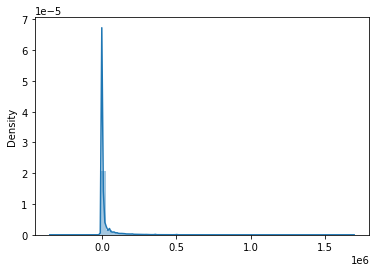

In [4]:
#checking the shape of the datasets
sns.distplot(df_def, kde=True)

In [5]:
#since it is approximately normal, we will standardize using z dist
x_std = preprocessing.scale(x).astype(np.float32)
y_std = preprocessing.scale(y).astype(np.float32)


## Logistic Regression

In [6]:
result_lr = []
for trial in range(5):
    #splitting into training and testing
    x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, train_size = 5000, random_state=trial,
                                                    stratify = y_std, shuffle=True)

    #encode training and testing data != continuous
    encode_ytr = preprocessing.LabelEncoder()
    ytr_encoded = encode_ytr.fit_transform(y_train)
    
    encode_yt = preprocessing.LabelEncoder()
    yt_encoded = encode_yt.fit_transform(y_test)
    
    C_list = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, np.Inf]
    alg = LogisticRegression(max_iter=5000, solver='saga')
    param_grid =  {'penalty' : ['l1', 'l2'], 'C': C_list}
    scoring_list = ['accuracy', 'precision', 'f1', 'roc_auc', 'recall']
    scoring_func_dict = {'acc':accuracy_score, 'AUC':roc_auc_score,
                        'prec':precision_score, 'recall':recall_score, 'f1':f1_score}
    scoring_dict = {k:make_scorer(v) for k,v in scoring_func_dict.items()}
    
    search_result = GridSearchCV (alg, param_grid, scoring=scoring_dict, refit=False, cv=5, n_jobs=-1)
    search_result.fit(x_train, ytr_encoded)
    
    res_one_trial = []
    for k in scoring_dict.keys():
        
        mean_test_metric = search_result.cv_results_['mean_test_'+k]
        best_idx = np.argmax(mean_test_metric)
        best_params = search_result.cv_results_['params'][best_idx]
        alg_new_5000 = LogisticRegression(max_iter=5000, solver='saga', **best_params)
        alg_new_5000.fit(x_train, ytr_encoded)
        
        res_test = alg_new_5000.predict(x_test)
        
        res_one_model = []
        for k_metric, func_metric in scoring_func_dict.items():
            metric_value = func_metric(res_test, yt_encoded)
            res_one_model.append(metric_value)

        res_one_trial.append(res_one_model)
    
    result_lr.append(res_one_trial)
result_lr = np.array(result_lr)
print(result_lr.shape)
print(np.mean(result_lr, axis=0))

(5, 5, 5)
[[0.809848   0.76201187 0.24097649 0.70561298 0.35865079]
 [0.809792   0.76064334 0.24347197 0.70249687 0.3607894 ]
 [0.798728   0.76420574 0.14636528 0.72597729 0.23990325]
 [0.809792   0.76064334 0.24347197 0.70249687 0.3607894 ]
 [0.809792   0.76064334 0.24347197 0.70249687 0.3607894 ]]


In [7]:
print([k for  k in scoring_dict.keys()])
print([k for k in scoring_func_dict.keys()])

['acc', 'AUC', 'prec', 'recall', 'f1']
['acc', 'AUC', 'prec', 'recall', 'f1']
